In [1]:
!git clone https://github.com/AbrahamCamelo/ResearchMethods_GitHub.git

Cloning into 'ResearchMethods_GitHub'...
remote: Enumerating objects: 483, done.
remote: Counting objects: 100% (483/483), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 483 (delta 408), reused 452 (delta 395), pack-reused 0 (from 0)
Receiving objects: 100% (483/483), 2.21 MiB | 8.48 MiB/s, done.
Resolving deltas: 100% (408/408), done.


In [4]:
!pip install -q -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.7 MB/s eta 0:00:00


In [31]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

Import the dataset

In [13]:
df_average = pd.read_csv('ResearchMethods_GitHub/ndvi_data/average_ndvi.csv')
df_average['date'] = pd.to_datetime(df_average.date)
df_average = df_average.drop(columns=['Unnamed: 0'])
lst_ndvi = np.array(df_average.NDVI)

In [14]:
n_steps_in = 30
n_steps_out = 6

In [17]:
scaler = MinMaxScaler()
lst_ndvi = scaler.fit_transform(lst_ndvi.reshape(-1, 1))

#### Function to restructure the data for the model

In [18]:
def prepare_data(data, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(data) - n_steps_in - n_steps_out):
        X.append(data[i:i+n_steps_in])
        y.append(data[i+n_steps_in:i+n_steps_in+n_steps_out])
    return np.array(X), np.array(y)

In [23]:
X, y = prepare_data(lst_ndvi, n_steps_in, n_steps_out)

## Keras tune
*   Definition of an integer hyperparameter: hp.Int(*hyperparameter*, min_value=#, max_value=#, step=#). This means that the *hyperparameter* will range from *min_value* to *max_value* inclusive with the minimum step for walking through the interval being *step*.



In [24]:
def build_model(hp):
    model = Sequential()
    model.add(
        LSTM(units=hp.Int('units', min_value=50, max_value=200, step=50),
             activation='relu',
             input_shape=(n_steps_in, 1))
    )
    model.add(Dense(n_steps_out))
    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']),
        loss='mse'
    )
    return model

### To initialize the tuner

* **hypermodel**. The model-building function, which is build_model in our case.
* **objective**. The name of the objective to optimize.



In [25]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='lstm_tuning',
    project_name='time_series_forecasting'
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [26]:
split = int(0.8 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

In [27]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stop])

Trial 7 Complete [00h 00m 14s]
val_loss: 0.021685852979620297

Best val_loss So Far: 0.020703492686152458
Total elapsed time: 00h 01m 55s


In [28]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.fit(X, y, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stop])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 215ms/step - loss: 0.0608 - val_loss: 0.0248
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0551 - val_loss: 0.0203
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0577 - val_loss: 0.0214
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0573 - val_loss: 0.0320
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0560 - val_loss: 0.0285
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0516 - val_loss: 0.0217
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0605 - val_loss: 0.0220


In [29]:
def forecast(model, input_sequence, n_steps_out):
    input_sequence = input_sequence.reshape((1, n_steps_in, 1))
    predictions = model.predict(input_sequence)
    return predictions[0]

In [30]:
input_sequence = lst_ndvi[-n_steps_in:]
predictions = forecast(best_model, input_sequence, n_steps_out)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

print("Predictions for the next 6 steps:", predictions.flatten())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
Predictions for the next 6 steps: [0.15203811 0.14948544 0.1540675  0.13920109 0.16840944 0.15590222]


In [37]:
print(r2_score(y, model.predict(X)))

(138, 1) (6, 1)


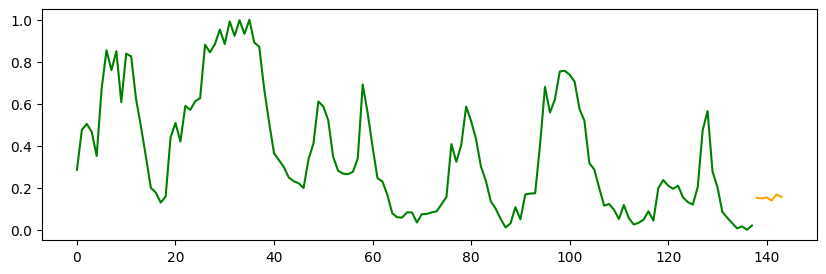

In [42]:
plt.figure(figsize=(10,3))
plt.plot(range(len(lst_ndvi),len(lst_ndvi)+len(predictions)), predictions, label = 'Predicted', c = 'orange')
plt.plot(lst_ndvi, label = 'Predicted', c = 'green')
plt.show()

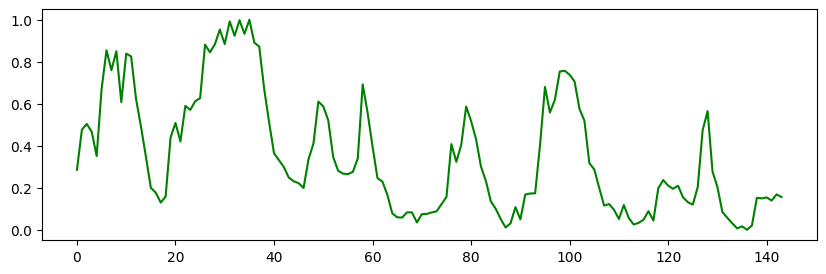

In [43]:
plt.figure(figsize=(10,3))
plt.plot(np.concatenate((lst_ndvi,predictions)), label = 'Predicted', c = 'green')
plt.show()